## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    all_lines = iofile.readlines()
    
LINE_START = 45
LINE_END = -368
lines = all_lines[LINE_START : LINE_END]
assert len(lines) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = "".join(lines).lower()
assert len(text) == 100225 # Are you sure you have concatenated all the strings?
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# create dicts <index>:<char> and <char>:<index>
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
batch_size = 32
num_tokens = len(tokens)
fixed_input_seq_length = 500
samples_count = batch_size * 100
samples_count_max = len(text) - fixed_input_seq_length

In [7]:
inputs, targets = [], []

for i in range(0, samples_count_max):
    inputs.append(text[i:i+fixed_input_seq_length])
    targets.append(text[i+fixed_input_seq_length])

In [8]:
import torch
from torch import nn
from torch.nn import functional as F

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # import ipdb; ipdb.set_trace()
        x_emb = self.embedding(x) # x -> (batch_size, seq_length) -> (batch_size, seq_length, embedding_size)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next) #YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) #YOUR CODE
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [18]:
def rnn_loop(char_rnn, batch_ix, hidden_state=None):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    input_batch_size = batch_ix.size(0)
    hidden_state = char_rnn.initial_state(input_batch_size)
    logits = []

    for x_t in batch_ix.transpose(0, 1):
        hidden_state, logits_next = char_rnn(x_t, hidden_state)
        logits.append(logits_next)

    return hidden_state, torch.stack(logits, dim=1)

In [10]:
def to_vector(batch_entry) -> torch.tensor:
  return [token_to_idx[token] for token in batch_entry]

def from_vector(vector: torch.tensor) -> list:
  return "".join([idx_to_token[idx] for idx in vector])

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [11]:
from IPython.display import clear_output
import numpy as np

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss()

history = []

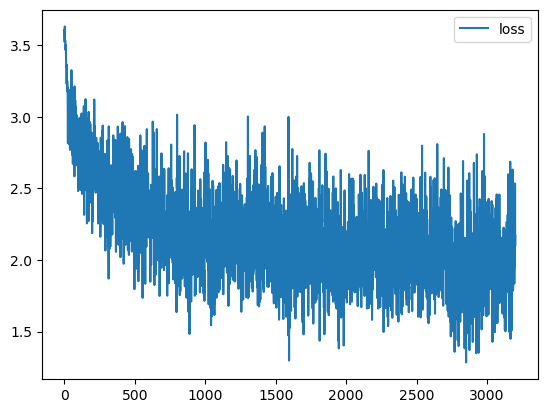

In [16]:
from matplotlib import pyplot as plt

hidden_state = char_rnn.initial_state(batch_size)

for i in range(samples_count_max // batch_size):
    batch_ix = inputs[i*batch_size:(i+1)*batch_size]
    batch_ix = torch.tensor([to_vector(entry) for entry in batch_ix], dtype=torch.int64)
    
    hidden_state, predictions_logits = rnn_loop(char_rnn, batch_ix, None)

    actual_next_tokens = torch.tensor([token_to_idx[token] for token in targets[i*batch_size:(i+1)*batch_size]], dtype=torch.int64)
    
    # compute loss
    loss = loss_func(
        predictions_logits[:, -1],
        actual_next_tokens
    )
    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [30]:
MAX_LENGTH = 100
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = torch.tensor([to_vector(seed_phrase)])
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [50]:
# An example of generated text.
print(generate_sample(char_rnn, seed_phrase="a man ", max_length=25, temperature=0.5))

a man bit bath to for the bith 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [97]:
# Using LSTM instead of RNN
class CharLSTM(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, states):
        (h_prev, c_prev) = states
        x_emb = self.embedding(x)
        output, (h_next, c_next) = self.lstm(x_emb, (h_prev, c_prev))
        logits = self.rnn_to_logits(output)
        return (h_next, c_next), logits
    
    def initial_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.num_units, requires_grad=True),
                torch.zeros(1, batch_size, self.num_units, requires_grad=True))

In [98]:
def rnn_lstm_loop(char_lstm, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    hidden_state = char_lstm.initial_state(batch_ix.size(0))  # Initialize hidden state with batch size
    logits = []

    for x_t in batch_ix.transpose(0, 1):
        hidden_state, logits_next = char_lstm(x_t, hidden_state)
        logits.append(logits_next)

    return hidden_state, torch.stack(logits, dim=1)

In [99]:
char_lstm = CharLSTM()
opt = torch.optim.Adam(char_lstm.parameters())
loss_func = nn.CrossEntropyLoss()

history = []

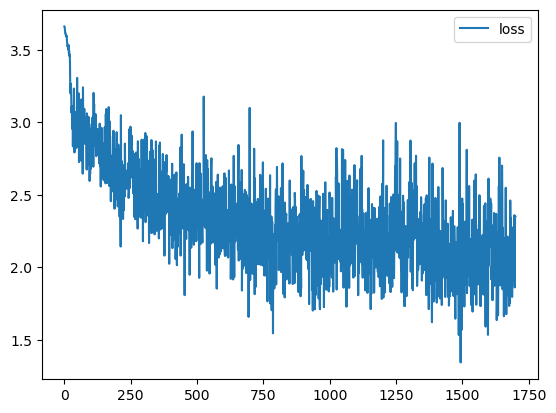

KeyboardInterrupt: 

In [113]:
for i in range(samples_count_max // batch_size):
    batch_ix = inputs[i*batch_size:(i+1)*batch_size]
    batch_ix = torch.tensor([to_vector(entry) for entry in batch_ix], dtype=torch.int64)
    batch_ix = batch_ix.unsqueeze(-1)

    hidden_state, predictions_logits = rnn_lstm_loop(char_lstm, batch_ix)

    actual_next_tokens = torch.tensor([token_to_idx[token] for token in targets[i*batch_size:(i+1)*batch_size]], dtype=torch.int64)
    
    # compute loss
    loss = loss_func(
        predictions_logits.squeeze(2)[:, -1],
        actual_next_tokens
    )
    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [131]:
def generate_sample_lstm(char_lstm, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    x_sequence = torch.tensor([to_vector(seed_phrase)])
    x_sequence = x_sequence.unsqueeze(-1)
    hid_state = char_lstm.initial_state(batch_size=1)

    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_lstm(x_sequence[:, i], hid_state)
    
    for _ in range(max_length):
        hid_state, out = char_lstm(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        next_ix = next_ix.unsqueeze(1)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.view(-1).numpy()])

In [136]:
# Text generation with different temperature values here
print("temp = 0.1:", generate_sample_lstm(char_lstm, seed_phrase="a man ", max_length=40, temperature=0.1))
print("temp = 0.2:", generate_sample_lstm(char_lstm, seed_phrase="a man ", max_length=40, temperature=0.2))
print("temp = 0.5:", generate_sample_lstm(char_lstm, seed_phrase="a man ", max_length=40, temperature=0.5))
print("temp = 1.0:", generate_sample_lstm(char_lstm, seed_phrase="a man ", max_length=40, temperature=1.0))
print("temp = 2.0:", generate_sample_lstm(char_lstm, seed_phrase="a man ", max_length=40, temperature=2.0))

temp = 0.1: a man the shere the the the the the the the th
temp = 0.2: a man the the the the the the the the thar the
temp = 0.5: a man syous art mane wof shime is and an malt 
temp = 1.0: a man ures at noese his therhe mou rife veaiic
temp = 2.0: a man thhicrtsece,kpfest, eit,h aly er!yqyorl;


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [52]:
# Saving the GRU model
torch.save(char_rnn.state_dict(), 'char_rnn.pth')

# Loading the GRU model
char_rnn_loaded = CharRNNCell()
char_rnn_loaded.load_state_dict(torch.load('char_rnn.pth'))
char_rnn_loaded.eval()

# An example of generated text.
print(generate_sample(char_rnn_loaded, "hello", max_length=100, temperature=0.5))

hellow'd love i mond than well and cantthe swore deart for the bistreld dering as all hath love oo kell f


In [140]:
# Saving the LSTM model
torch.save(char_lstm.state_dict(), 'char_lstm.pth')

# Loading the LSTM model
char_lstm_loaded = CharLSTM()
char_lstm_loaded.load_state_dict(torch.load('char_lstm.pth'))
char_lstm_loaded.eval()

print("temp = 0.1:", generate_sample_lstm(char_lstm_loaded, "hello", max_length=100, temperature=0.5))

temp = 0.1: hello ory thar ins you thine thite so wire angen shings bore ing in the in mees aly you iw it beand wat p


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)